In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Filtering Non-Human Clicks from Wikipedia Pageview Data

In this activity, we're asked to filter bot traffic from pageview data. The data lives in [data/wikipedia_pageviews.csv.gz](../../data/wikipedia_pageviews.csv.gz).

First, we need to load the data, and then we can get to work on the assignment.

In [2]:
df = pd.read_csv('../../data/wikipedia_pageviews.csv.gz')

In [3]:
df.head() # check to see that it loaded

,timestamp,ip_address,user_agent,project,page_title,count,referer,response_size
0,2024-01-15T00:00:00Z,13155695996c,SemrushBot/7~bl (+http://www.semrush.com/bot/),ru.wikipedia,Wikipedia:Featured_articles,1,NaN,8739
1,2024-01-15T00:00:00Z,2223496a77ec,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:1...,zh.wikipedia,Solar_System,1,https://www.reddit.com/,77536
2,2024-01-15T00:00:00Z,6aa13263355b,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:1...,en.wikipedia,Biodiversity,1,NaN,64317
3,2024-01-15T00:00:00Z,5f8db1edf904,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,commons.wikimedia,Quantum_mechanics,1,https://www.facebook.com/,51552
4,2024-01-15T00:00:00Z,47d4dd260c7d,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,es.wikipedia,List_of_countries_by_population,1,https://www.reddit.com/,57821


## Data Understanding

To explain the fields, we need to know what they are.

In [4]:
print(df.columns) # print the column names

Index(['timestamp', 'ip_address', 'user_agent', 'project', 'page_title',
       'count', 'referer', 'response_size'],
      dtype='object')


Here's a table of the columns and what I think they mean:

| column_name | description |
| :--- | :--- |
| timestamp | the time that the page was viewed |
| ip_address | the IP address of the page viewer |
| user_agent | the request header from the page viewer |
| project | which wikipedia the page is on |
| page_title | the page's name |
| count | I'm not sure about this one |
| referrer | where the link to the page was that the viewer clicked on |
| response_size | how big the page was |

There's one field I'm not sure about, so let's look at some data and see if I can figure out what it is.

In [31]:
frequencies = df['count'].value_counts(dropna=False, normalize=True)
print(frequencies)

count
1     0.983158
10    0.005660
25    0.005606
5     0.005576
Name: proportion, dtype: float64


I'm still not sure what `count` means, but maybe it's aggregating this IP-referrer-page combination?

## Hypothesis Formation

Now I know what's in the data. I need at least 3 hypotheses about non-human traffic that I can test. Here are some:

1. Bots tend to make a large number of requests in a short amount of time.
2. Bots visit pages in alphabetical order, like they're following a list.
3. Bots may exhibit unusual patterns in the distribution of pageviews across different projects (e.g., language versions of Wikipedia).
4. Bots might have user agents that identify them as automated tools.
5. Bots might lack a user agent entirely.
6. Bots might show a burst of requests.
7. Bots might access pages that aren't typical Wikipedia entries.

## Filtering Strategy

What are some filtering or analysis strategies that would test those hypotheses?

1. Filter out entries where the agent field contains keywords associated with bots (e.g., 'bot', 'crawler').
2. Calculate the average number of pageviews per IP address per hour. Filter out IP addresses that exceed a certain threshold.
3. Analyze the distribution of pageviews across projects. Identify projects that exhibit unusually high or low traffic from specific IP addresses.
4. Calculate requests per IP address per hour and filter out really high values.
5. Identify IPs that are outliers in request frequency.
6. Filter out IPs that have very low times between requests.

## Implementation

Implement some of those filtering strategies.

Starting with an easy one that looks for obvious bot referrers. Let's look at the referrers and see if we can tell bots from not-bots.


In [6]:
# show the frequency of each referrer
frequencies = df['user_agent'].value_counts(dropna=False)
print(frequencies)

user_agent
Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36                            184702
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36                      184529
Mozilla/5.0 (iPhone; CPU iPhone OS 17_2 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/17.2 Mobile/15E148 Safari/604.1    184485
Mozilla/5.0 (iPad; CPU OS 17_2 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/17.2 Mobile/15E148 Safari/604.1             184266
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/17.2 Safari/605.1.15                      184180
Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36                                      184053
Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:121.0) Gecko/20100101 Firefox/121.0                                 

In [7]:
# Make a list of keywords to look for in referrers
bot_keywords = ['bot', 'crawler',  'spider', 'scrapy', 'wget', 'curl', 'python-requests']

# make a dataframe with just obvious bot requests
# this converts the `user_agent` text to lowercase and checks if it contains the words in our list, all in one line
obvious_bots = df[df['user_agent'].str.lower().str.contains('|'.join(bot_keywords), na=False)]

# check to see if that data makes sense
obvious_bots.head()

,timestamp,ip_address,user_agent,project,page_title,count,referer,response_size
0,2024-01-15T00:00:00Z,13155695996c,SemrushBot/7~bl (+http://www.semrush.com/bot/),ru.wikipedia,Wikipedia:Featured_articles,1,NaN,8739
17,2024-01-15T00:00:00Z,70f24e3c28c2,curl/7.68.0,meta.wikimedia,Renewable_energy,1,NaN,36531
19,2024-01-15T00:00:00Z,0b0d2863f0ab,ia_archiver (+http://www.alexa.com/site/help/w...,ar.wikipedia,Photosynthesis,1,https://www.google.com/,32238
22,2024-01-15T00:00:00Z,d2db5aa0c02c,ia_archiver (+http://www.alexa.com/site/help/w...,wikidata.org,List_of_countries_by_population,1,NaN,14769
24,2024-01-15T00:00:00Z,b721a80c8e37,Mozilla/5.0 (compatible; YandexBot/3.0; +http:...,wikidata.org,Photosynthesis,1,NaN,33273


In [8]:
# How big is the bot dataset relative to the whole dataset?
print(f"Pageviews with obvious bot-like user agents: {len(obvious_bots)} ({len(obvious_bots)/len(df)*100:.1f}%)")


Pageviews with obvious bot-like user agents: 316063 (15.8%)


Now let's calculate the number of pageviews per IP per hour and see if there are outliers.

I used the CoPilot chat within VS Code to generate much of the rest of this notebook because I wanted to see how the AI would answer. 

In [15]:
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce", utc=True)

# Normalize time to UTC (optional, but recommended if mixed tz info)
if df["timestamp"].dt.tz is None:
    # treat naive timestamps as UTC; alternatively localize to a known timezone with tz_localize
    df["timestamp"] = df["timestamp"].dt.tz_localize("UTC")

# Create an hourly bucket
df["day"] = df["timestamp"].dt.floor("d")  # or dt.strftime('%Y-%m-%d %H:00:00') for string buckets

# Drop rows with missing IP or timestamp (or decide how to handle them)
df = df.dropna(subset=["ip_address", "day"])

# Group and count pageviews per IP per hour
result = df.groupby(["ip_address", "day"], observed=True).size().reset_index(name="pageviews")

# Sort if you like
result = result.sort_values(["ip_address", "day"])

# Preview
print(result.head(5))

     ip_address                       day  pageviews
0  000002ebcd68 2024-01-15 00:00:00+00:00          1
1  0000139283f2 2024-01-15 00:00:00+00:00          1
2  00001ad3d5d5 2024-01-15 00:00:00+00:00          1
3  00002b42c422 2024-01-15 00:00:00+00:00          1
4  0000355f2711 2024-01-15 00:00:00+00:00          1


The AI didn't encourage me to visualize the distribution. That's a missing step that can be helpful. So, I'm adding a cell to look at the distribution.

I also notice that the AI creates a new dataframe called "result". Generally I like to name things so that I know what's in them or what they are. I recommend renaming that `result` dataframe to something more descriptive. 

In [23]:
df_pageviews = result

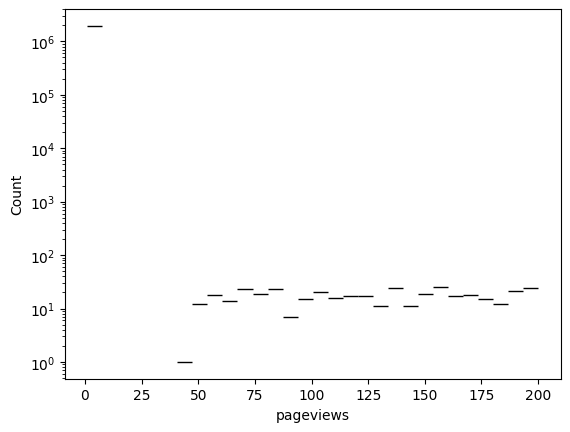

In [28]:
# Plot
sns.histplot(df_pageviews['pageviews'], bins=30, log_scale=(False, True))
plt.show()

That looks weird. Why isn't there any variance? Let's look at the frequencies of pageview values.

In [25]:
# show the frequency of pageviews
frequencies = df_pageviews['pageviews'].value_counts(dropna=False)
print(frequencies)

pageviews
1      1948928
2          471
158          8
69           7
86           7
        ...   
143          1
99           1
43           1
133          1
104          1
Name: count, Length: 148, dtype: int64


The frequency table shows that almost 2M IPs viewed only 1 page. That seems weird based on my experience with Wikipedia, but it also doesn't seem bot-like. Let's see what this looks like if we remove the 1-page IPs.

In [26]:
df_multi_pageviews = df_pageviews.drop(df_pageviews[df_pageviews.pageviews < 2].index)
print(len(df_multi_pageviews))

870


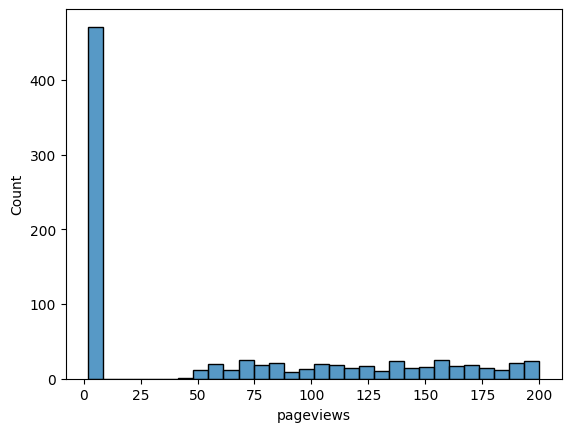

In [27]:
# Plot
sns.histplot(df_multi_pageviews['pageviews'], bins=30)
plt.show()

That looks more like what I would expect - high frequencies of low pageviews, and lower frequencies of high pageviews. What I don't see, that I was hoping for, is a natural break somewhere else in the distribution that would make it easy to tell bots from humans. There's a break between 2 and about 50, but I'm not sure how many pages I expect humans to view.

In [30]:
df_pageviews['pageviews'].describe()

count    1.949798e+06
mean     1.025747e+00
std      1.892760e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      2.000000e+02
Name: pageviews, dtype: float64